# **Proyecto inteligencia artificial.**

# **Detección de firmas falsas.**

### **Estadística. Facultad de Ciencias. Universidad Nacional de Colombia.**

### **Autores:**
  - [Michel Mendivenson Barragán Zabala](mbarraganz@unal.edu.co)
  - [Julieta Ruiz Castiblanco](druizca@unal.edu.co)
  - [Nataly Astrid Quintero Ardila](nquinteroa@unal.edu.co)



---


La detección de firmas falsas es un desafío crucial en el mundo actual, donde la autenticidad de documentos y transacciones legales es esencial. Los métodos manuales de verificación de firmas son propensos a errores y costosos en términos de tiempo y recursos. En respuesta a esta necesidad, se plantea este proyecto de aprendizaje profundo con el objetivo de desarrollar un sistema automático capaz de distinguir firmas auténticas de firmas falsificadas.

Este proyecto se basa en el poder del aprendizaje profundo, una rama de la inteligencia artificial que ha demostrado su eficacia en una amplia gama de aplicaciones de visión por computadora. Aquí, aplicamos este enfoque para abordar un problema de seguridad crítico. A lo largo de esta demostración, exploraremos cómo entrenar un modelo de aprendizaje profundo para realizar esta tarea de detección de firmas falsas con una precisión excepcional.

Nuestra motivación radica en la necesidad de mejorar la seguridad en documentos legales, prevenir fraudes y simplificar la verificación de firmas. A medida que avanzamos en esta demostración, demostraremos cómo el aprendizaje profundo puede ofrecer una solución eficaz para este desafío. Verás cómo entrenar un modelo de aprendizaje profundo para reconocer patrones y características en las firmas que escapan al ojo humano.

El proceso involucra la adquisición y preparación de datos, la selección de un modelo adecuado, el entrenamiento del modelo y la evaluación de su desempeño. A través de ejemplos prácticos, demostraremos cómo se realiza cada uno de estos pasos. Además, discutiremos la importancia de los datos de validación para garantizar que el modelo pueda generalizar de manera efectiva y evitar el sobreajuste.

## **La base de datos:**

La base de datos se encuentra alojada en la carpeta `sign_data` (Obtenida del siguiente [enlace](https://www.kaggle.com/datasets/robinreni/signature-verification-dataset) ) estructurada de la siguiente forma:


In [25]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# La siguiente línea cambiará en función de donde estén almacenados los datos, pero en este caso particular:
os.chdir('/content/drive/Shareddrives/2023-II/2023-II. Inteligencia Artificial (IA)/Proyecto IA') # Ruta Mendivenson
# os.chdir('/content/drive/My Drive/Proyecto IA') # Ruta Julieta
os.listdir('sign_data')

['test_data.csv',
 'train_data.csv',
 'test',
 'train',
 'train_data',
 'validation_data',
 'test_data',
 'signature_data']


  - En la carpeta se encuentran dos carpetas y dos archivos csv.
    - La carpeta `train` corresponde a los datos de entrenamiento.
    - La carpeta `test` corresponde a los datos de prueba (Aunque ya están metidos dentro de entrenamiento)
    - El archivo `train_data.csv` y el archivo `test_data.csv` corresponde a archivos de identificadores para cada una de las carpetas (Nos dan información sobre si una imagen específica dentro de las carpetas de los datos de entrenamiento o test correpsonde a una firma falsa o genuina).

Sin embargo, estos archivos `.csv` no los usaremos tanto debido a que las carpetas como tal tienen estructura que nos brinda esta información. Veamos:

In [27]:
sorted(os.listdir('sign_data/train'))[-10:-1]

['065',
 '065_forg',
 '066',
 '066_forg',
 '067',
 '067_forg',
 '068',
 '068_forg',
 '069']

Dentro de cada una de las carpetas se encuentran más carpetas numeradas del uno al 69 siendo cada una de estas carpetas asignada para un individuo en específico y por cada individuo en específico hay dos sets de datos: `0##` conteniendo el set de firmas genuinas del individuo ## y `0**_forg` conteniendo el set de firmas falsas del individuo.

In [28]:
print(f'Hay {len(os.listdir("sign_data/train/001"))} firmas genuinas para cada individuo y {len(os.listdir("sign_data/train/001_forg"))} falsas.')

Hay 24 firmas genuinas para cada individuo y 8 falsas.


## **Preprocesamiento de los datos:**

Con el preprocesamiento queremos, en general alcanzar dos objetivos:

- Convertir las imágenes a blanco y negro.
- Dejar la misma altura y ancho para todas las imágenes.
- Organizar los datos entre datos de entrenamiento, validación y datos de prueba.

In [29]:
import cv2
from tqdm import tqdm
from google.colab.patches import cv2_imshow
os.chdir('sign_data')

  ### **Convirtiendo las imágenes a blanco y negro:**

  El módulo de python `cv2` nos brinda herramientas tanto para la visualización como para la manipulación de imágenes:

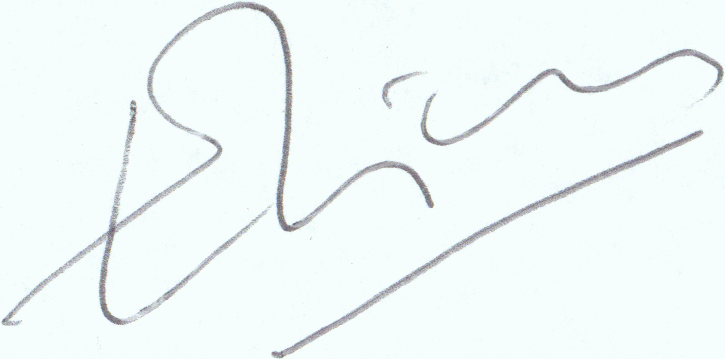

(359, 725, 3)

In [30]:
img = cv2.imread('train/001/001_01.PNG')
cv2_imshow(img)
# El siguiente comando nos da una tupla con la siguiente información del objeto img
img.shape
# (altura en píxeles, cncho en píxeles, canales de color de la imagen)

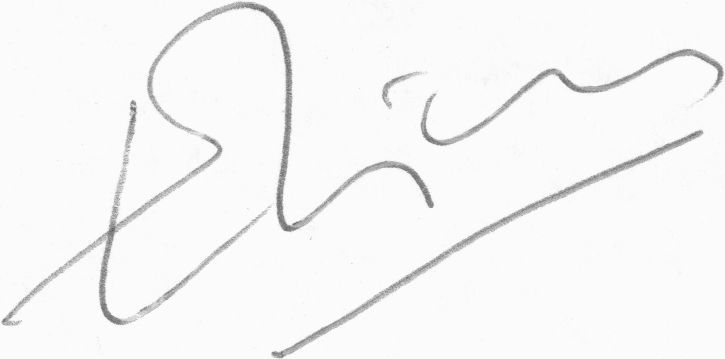

(359, 725)

In [31]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(img_gray)
# Note que en el siguiente comando
img_gray.shape
# Ya no aparecen argumento para los canales de color de la imagen.
# Es decir, hemos convertido la imagen a blanco y negro

### **Mismo alto y ancho:**

1. Obtenemos el ancho y alto de todas las imágenes:

In [34]:
import pandas as pd
pd.options.mode.chained_assignment = None

height = []
width = []
for name in tqdm(os.listdir('train')):
    for image_name in os.listdir('train/'+name):
        img = cv2.imread('train/'+name+'/'+image_name)
        h, w, _ = img.shape
        height.append(h)
        width.append(w)

100%|██████████| 128/128 [00:10<00:00, 12.09it/s]


Note que efctivamente las alturas y anchos de las imágenes en píxeles son distintos para cada imagen:

In [35]:
print(height[0:10])
print(width[0:10])

[379, 346, 240, 235, 308, 376, 346, 329, 231, 173]
[723, 726, 911, 781, 826, 881, 814, 757, 791, 821]


2. Definimos un ancho y alto estándar:

In [36]:
mean_height = int(sum(height)/len(height))
mean_width = int(sum(width)/len(width))
print(f'El ancho para todas las imágenes será {mean_width} y el alto {mean_height}')

El ancho para todas las imágenes será 650 y el alto 268


### **Organizando las imágenes en blanco y negro del mismo tamaño en carpetas para la validación, el entrenamiento y los datos de prueba:**

1. Creamos las carpetas de entrenamiento, de prueba y de validación:

In [37]:
os.chdir('/content/drive/Shareddrives/2023-II/2023-II. Inteligencia Artificial (IA)/Proyecto IA/sign_data')
# os.chdir('/content/drive/My Drive/Proyecto IA/sign_data')
os.mkdir('../signature_data')
os.chdir('../signature_data')
os.mkdir('train_data')
os.mkdir('validation_data')
os.mkdir('test_data')

2. Clasificación y transformación de las imágenes para darles la misma altura y ancho:

**Nota:** La carpeta `signatura_data` va a estar estructurada de la misma forma que la carpeta `sign_data`: Cada carpeta dentro de las subcarpetas se corresponderá a un individuo en específico.

In [38]:
for name in tqdm(os.listdir('../sign_data/train')):
    num_images = len(os.listdir('../sign_data/train/'+name))
    i = 0
    os.mkdir('train_data/'+name)
    os.mkdir('validation_data/'+name)
    os.mkdir('test_data/'+name)
    for image_name in sorted(os.listdir('../sign_data/train/'+name)):
        img = cv2.imread('../sign_data/train/'+name+'/'+image_name)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_resized = cv2.resize(img_gray, (mean_width, mean_height))
        if i < 7 * (num_images/10):
            cv2.imwrite('train_data/'+name+'/'+image_name, img_resized)
        elif i < 9 * (num_images/10):
            cv2.imwrite('validation_data/'+name+'/'+image_name, img_resized)
        else:
            cv2.imwrite('test_data/'+name+'/'+image_name, img_resized)
        i += 1

100%|██████████| 128/128 [00:31<00:00,  4.10it/s]


Note que efectivamente las imágenes quedaron bien transformadas:

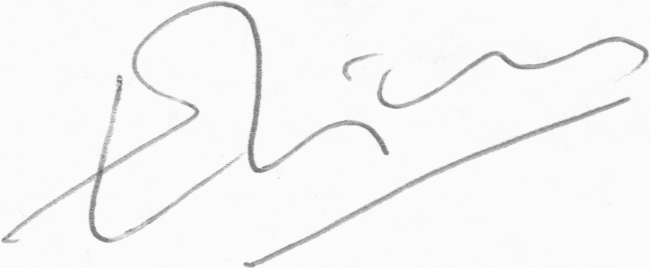

(268, 650, 3)

In [39]:
img = cv2.imread('train_data/001/001_01.PNG')
cv2_imshow(img)
img.shape

### **Lectura y almacenamiento de las imágenes:**


In [40]:
# Si se está trabajando en google collab se recomienda cambiar
# de CPU a T4 GPU en la sección 'Change runtime type' para que
# llegada la parte de entrenamiento del modelo el tiempo de
# ejecución sea menor.
import os
import cv2
from tqdm import tqdm
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/Shareddrives/2023-II/2023-II. Inteligencia Artificial (IA)/Proyecto IA/signature_data')
#os.chdir('/content/drive/My Drive/Proyecto IA/sign_data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
import numpy as np

def get_data(dir, labels = True):
    features = []
    targets = []
    for name in tqdm(sorted(os.listdir(dir))):
        for image_name in sorted(os.listdir(dir+'/'+name)):
            img = cv2.imread(dir+'/'+name+'/'+image_name)#, cv2.IMREAD_GRAYSCALE)
            features.append(img)
            if labels:
                if 'forg' in name.lower():
                    targets.append(1)
                else:
                    targets.append(0)
    if labels:
        return np.array(features),np.array(targets)
    else:
        return np.array(features)

In [46]:
train_features, train_labels = get_data('train_data', labels = True)
validation_features, validation_labels = get_data ('validation_data', labels = True)
test_features, test_labels = get_data('test_data', labels = True)

100%|██████████| 128/128 [00:01<00:00, 65.71it/s]


In [43]:
print(train_features.shape)
print(validation_features.shape)
print(test_features.shape)

(1226, 268, 650, 3)
(298, 268, 650, 3)
(125, 268, 650, 3)


In [ ]:
# Firmas reales
r = np.where(train_labels[0:(len(train_features[3]))] == 0)[0][1]
# Firmas falsas
f = np.where(train_labels[0:(len(train_features[3]))] == 1)[0][1]

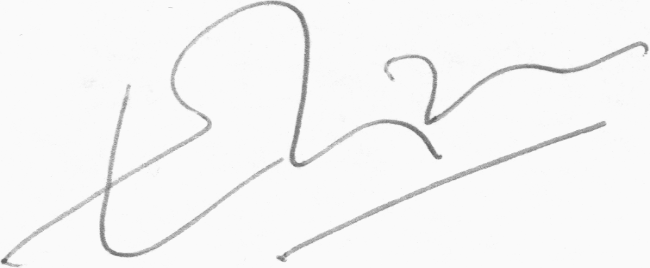

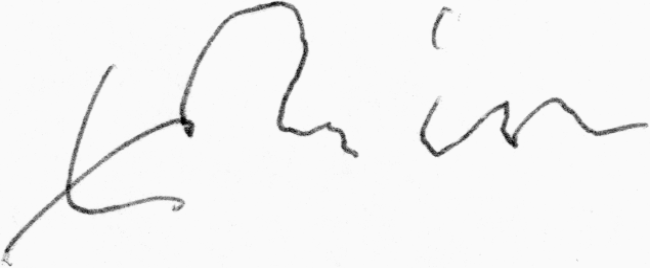

In [ ]:
cv2_imshow(train_features[r])
cv2_imshow(train_features[f])
del(r,f)

In [47]:
train_features = train_features.reshape((1226, 268, 650, 3))
train_features = train_features.astype('float32') / 255
validation_features = validation_features.reshape((298, 268, 650, 3))
validation_features = validation_features.astype('float32') / 255
test_features = test_features.reshape((125, 268, 650, 3))
test_features = test_features.astype('float32') / 255

## **CREACIÓN DE LOS MODELOS:**

Con fines comparativos se generán varios modelos

- Modelo básico de CNN
- Inception-v3
- VGG16
- Oneshot learning

---

### **RED NEURONAL CONVOLUCIONAL**

#### **Entrenamiento del modelo**

In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# train_features = np.expand_dims(train_features, axis=-1)
# validation_features = np.expand_dims(validation_features, axis=-1)
# test_features = np.expand_dims(test_features, axis=-1)

model = Sequential([
    # Convolutional layer with 32 filters, a kernel size of 3 and ReLU activation
    Conv2D(32, (3, 3), activation='relu', input_shape=(268, 650, 3)),
    MaxPooling2D((2, 2)),
    # Second convolutional layer with 64 filters
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    # Third convolutional layer with 128 filters
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    # Dense layer with 128 units
    Dense(128, activation='relu'),
    Dropout(0.5),
    # Output layer with single neuron, as we are doing binary classification
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer and binary crossentropy loss
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
import time

start_time = time.time()
# Suponiendo que 'history' es el objeto devuelto por 'model.fit()'
history = model.fit(train_features, train_labels, epochs=15,
                    validation_data=(validation_features, validation_labels))
end_time = time.time()

Epoch 1/15
39/39 [==============================] - 597s 15s/step - loss: 2.5193 - accuracy: 0.4943 - val_loss: 0.6701 - val_accuracy: 0.4732
Epoch 2/15


#### **Resultados**

##### **Modelo:**

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 266, 648, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 133, 324, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 131, 322, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 65, 161, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 159, 128)      73856     
                                                                 
 flatten (Flatten)           (None, 1282176)           0

In [ ]:
print(f'El modelo tardo {(end_time - start_time)/60} minutos en entrenarse.')

El modelo tardo 2.855630648136139 minutos en entrenarse.


##### **Precisión y pérdida**

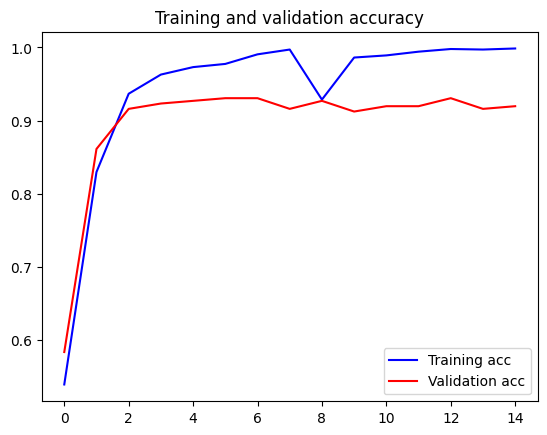

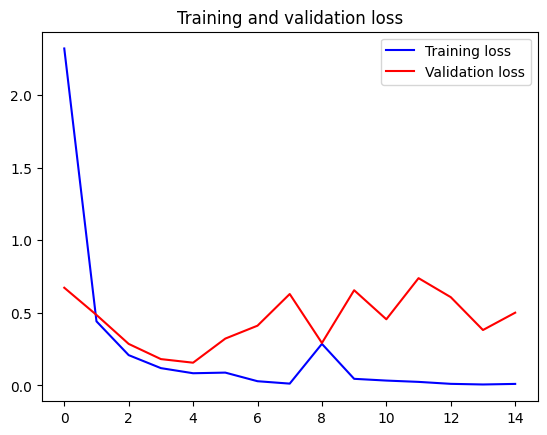

In [ ]:
from matplotlib import pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
import pandas as pd
from IPython.display import HTML

# Valores finales:
resultados = np.array([[history.history['accuracy'][-1], history.history['loss'][-1]],
                       [history.history['val_accuracy'][-1], history.history['val_loss'][-1]]])

df = pd.DataFrame(resultados, index = ['Entrenamiento','Validación'],
                  columns = ['Precisión','Pérdida'])

display(HTML(df.to_html()))

,Precisión,Pérdida
Entrenamiento,0.998545,0.009959
Validación,0.919708,0.500625


#### **Comprobando la precisión con los datos de prueba**

In [ ]:
a = %who_ls
borrar = list(filter(lambda x: 'test' in x, a))
borrar += list(filter(lambda x: 'test' in x, a))
a = list(filter(lambda x: x not in borrar, a))
a.remove('model')
a.remove('resultados')
for i in a:
  del globals()[i]
del a
del borrar
del i
%who_ls

['model', 'resultados', 'test_features', 'test_labels']

In [ ]:
# Evaluate the model with the test data
test_loss, test_acc = model.evaluate(test_features, test_labels)
print(f'Los resultados de la evaluación con los datos de prueba fueron:\n'
      f'- Precisión: {test_acc:.4f}\n- Pérdida: {test_loss:.4f}')

16/16 [==============================] - 2s 98ms/step - loss: 0.0310 - accuracy: 0.9900
Los resultados de la evaluación con los datos de prueba fueron:
- Precisión: 0.9900
- Pérdida: 0.0310


In [ ]:
import numpy as np
import pandas as pd
from IPython.display import HTML
# Precisión: Tasa de clasifiación correcta.
# Pérdida  : Cuán cerca está la salida del modelo de las etiquetas reales.
resultados = np.vstack((resultados, [test_acc,test_loss]))
df = pd.DataFrame(resultados, index = ['Entrenamiento','Validación','Test'],
                  columns = ['Precisión','Pérdida'])
display(HTML(df.to_html()))

,Precisión,Pérdida
Entrenamiento,0.998545,0.009959
Validación,0.919708,0.500625
Test,0.990000,0.030951


#### **Guardando el modelo**

In [ ]:
import os
os.chdir('..')
model.save('CNN.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


---

### **VGG16**

VGG16, que significa "Visual Geometry Group 16," es una arquitectura de red neuronal convolucional (CNN) diseñada por el grupo de investigación Visual Geometry Group de la Universidad de Oxford. VGG16 es una de las arquitecturas de CNN más influyentes y ampliamente utilizadas en la comunidad de aprendizaje profundo, y se ha convertido en un punto de referencia para tareas de clasificación de imágenes.




In [ ]:
# Importando el modelo
from keras.applications import VGG16

# El modelo usará los pesos pre entrenados con la base de datos de imagenet
# con inputs de 268 * 650 y 3 canales de color
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(268, 650, 3))

# TRANSFER LEARNING:
# El modelo no se volverá a entrenar: Los pesos del modelo entrenados con imagenet
# se mantendrán
for k,v in  conv_base._get_trainable_state().items():
    k.trainable = False

# Extraer los pesos preentrenados:
# model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# weights = model.get_weights()

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
from keras import layers
from keras import models
from keras import optimizers

# Se crea un modelo secuencial:
end_model = models.Sequential()

# Se agrega a este último modelo una capa de aplanamiento: La salida de
# VGG16 se transforma en un vector unidimensional.
end_model.add(layers.Flatten(input_shape=conv_base.output_shape[1:]))

# Capas de aprendizaje intermedio
end_model.add(layers.Dense(64, activation='relu'))
end_model.add(layers.Dense(64, activation='relu'))

# Esta última capa es una capa densamente conectada con una unidad. En últimas esta
# capa nos dirá si la firma dada es falsa o verdadera.
end_model.add(layers.Dense(1, activation='sigmoid'))

# Combinamos el modelo VGG16 (En este caso llamado `conv_base`) y el modelo
# secuencial end_model
model = models.Model(inputs=conv_base.input, outputs=end_model(conv_base.output))

# Se compila el modelo con un optimizador RMsprop (Con una taza de aprendizaje de 10^-6) y
# la función de pérdida `binary_crossentropy` (Apropiada para problemas de clasificación)
# binarios.
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-6),
              loss='binary_crossentropy',
              metrics=['accuracy'])

#### **Entrenamiento del modelo**

In [ ]:
import time
# El modelo VGG16 + red secuencial se entrena acá¿ usando los datos de entrenamiento
# como entrenamiento (Recuerde que 0 es una firma genuina y uno una firma falsa):
# + epochs          : Iteraciones completas a tráves de todo el conjunto de datos.
# + batch_size      : Cuántas muestras por vez se usarán para el entrenamiento.
# + validation_data : Los datos de la validación del rendimiento del modelo.

start_time = time.time()
history = model.fit(train_features, train_labels,
                    epochs=100, batch_size=32,
                    validation_data=(validation_features, validation_labels))
end_time = time.time()

Epoch 1/100
43/43 [==============================] - 65s 1s/step - loss: 0.6944 - accuracy: 0.5418 - val_loss: 0.6772 - val_accuracy: 0.5949
Epoch 2/100
43/43 [==============================] - 28s 653ms/step - loss: 0.6756 - accuracy: 0.5920 - val_loss: 0.6628 - val_accuracy: 0.6277
Epoch 3/100
43/43 [==============================] - 27s 624ms/step - loss: 0.6576 - accuracy: 0.6480 - val_loss: 0.6481 - val_accuracy: 0.6642
Epoch 4/100
43/43 [==============================] - 28s 652ms/step - loss: 0.6376 - accuracy: 0.6858 - val_loss: 0.6306 - val_accuracy: 0.7117
Epoch 5/100
43/43 [==============================] - 28s 647ms/step - loss: 0.6140 - accuracy: 0.7331 - val_loss: 0.6097 - val_accuracy: 0.7080
Epoch 6/100
43/43 [==============================] - 27s 635ms/step - loss: 0.5866 - accuracy: 0.7636 - val_loss: 0.5864 - val_accuracy: 0.7591
Epoch 7/100
43/43 [==============================] - 28s 648ms/step - loss: 0.5588 - accuracy: 0.8029 - val_loss: 0.5677 - val_accuracy: 0.

#### **Resultados**

##### **Modelo:**

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 268, 650, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 268, 650, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 268, 650, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 134, 325, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 134, 325, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 134, 325, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 67, 162, 128)      0     

In [ ]:
print(f'El modelo tardó {(end_time - start_time)/60} minutos en entrenarse.')

El modelo tardó 48.10661063194275 minutos en entrenarse.


##### **Precisión y pérdida**

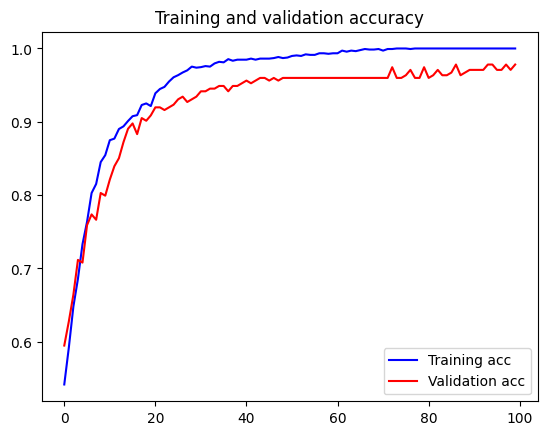

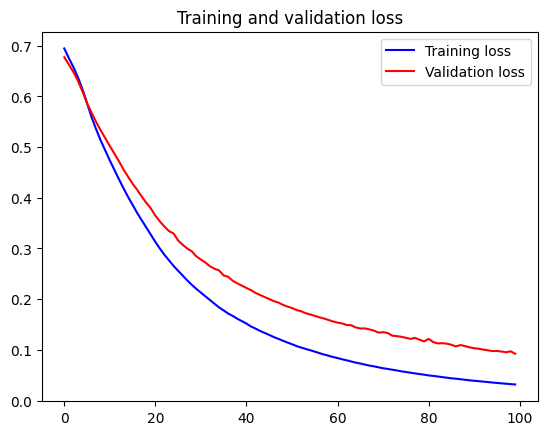

In [ ]:
from matplotlib import pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
import pandas as pd
from IPython.display import HTML

# Valores finales:
resultados = np.array([[history.history['accuracy'][-1], history.history['loss'][-1]],
                       [history.history['val_accuracy'][-1], history.history['val_loss'][-1]]])

df = pd.DataFrame(resultados, index = ['Entrenamiento','Validación'],
                  columns = ['Precisión','Pérdida'])

display(HTML(df.to_html()))

,Precisión,Pérdida
Entrenamiento,1.000000,0.031794
Validación,0.978102,0.092425


#### **Comprobando la precisión con los datos de prueba**

In [ ]:
# Al agregar más datos a los datos de validación y entrenamiento el modelo es más
# pesado y consume más memoria RAM por ende Collab puede llegar a fallar al hacer
# el test en la siguiente celda. Por eso existe esta línea.
# Para liberar memoria y que no se quedé sin espacio en RAM
a = %who_ls
a.remove('model')
a.remove('test_features')
a.remove('test_labels')
a.remove('resultados')
for i in a:
  del globals()[i]
del i
%who_ls

['a', 'i', 'model', 'resultados', 'test_features', 'test_labels']

In [ ]:
test_loss, test_acc = model.evaluate(test_features, test_labels)

16/16 [==============================] - 15s 935ms/step - loss: 0.2409 - accuracy: 0.8940


In [ ]:
import numpy as np
import pandas as pd
from IPython.display import HTML

# Precisión: Tasa de clasificación correcta.
# Pérdida  : Cuán cerca está la salida del modelo de las etiquetas reales.
resultados = np.vstack((resultados, [test_acc,test_loss]))
df = pd.DataFrame(resultados, index = ['Entrenamiento','Validación','Test'],
                  columns = ['Precisión','Pérdida'])
display(HTML(df.to_html()))

,Precisión,Pérdida
Entrenamiento,1.000000,0.031794
Validación,0.978102,0.092425
Test,0.894000,0.240902


#### **Guardando el modelo**

In [ ]:
import os
os.chdir('..')
model.save('vgg16.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


---

### **INCEPTION-V3**


Inception-v3 es una arquitectura de red neuronal convolucional (CNN) diseñada para tareas de visión por computadora, específicamente para clasificación de imágenes. Su capacidad para capturar información a múltiples escalas mediante módulos de convolución hace que sea especialmente útil para la detección de características complejas en imágenes.

In [ ]:
from keras.applications import InceptionV3
from keras import layers
from keras import models
from keras import optimizers

# Importar el modelo Inception-v3 con pesos preentrenados en ImageNet
conv_base_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(268, 650, 3))

# Transfer Learning: Congelar los pesos del modelo preentrenado
for layer in conv_base_inception.layers:
    layer.trainable = False

# Crear el modelo secuencial para agregar capas personalizadas
end_model_inception = models.Sequential()

# Añadir una capa de aplanamiento a la salida de Inception-v3
end_model_inception.add(layers.Flatten(input_shape=conv_base_inception.output_shape[1:]))

# Añadir capas de aprendizaje intermedio
end_model_inception.add(layers.Dense(64, activation='relu'))
end_model_inception.add(layers.Dense(64, activation='relu'))

# Añadir una capa densa final con una unidad de salida (problema de clasificación binaria)
end_model_inception.add(layers.Dense(1, activation='sigmoid'))

# Combinar el modelo Inception-v3 con el modelo secuencial personalizado
model_inception = models.Model(inputs=conv_base_inception.input, outputs=end_model_inception(conv_base_inception.output))

# Compilar el modelo con el optimizador RMSprop y la función de pérdida binary_crossentropy
model_inception.compile(optimizer=optimizers.RMSprop(learning_rate=1e-6), loss='binary_crossentropy', metrics=['accuracy'])


#### **Entrenar el modelo**

In [ ]:
import time

start_time = time.time()
# Entrenar el modelo con los datos de entrenamiento y validación
history_inception = model_inception.fit(train_features, train_labels,
                                        epochs=15, batch_size=32,
                                        validation_data=(validation_features, validation_labels))
end_time = time.time()

Epoch 1/15
43/43 [==============================] - 45s 650ms/step - loss: 0.6679 - accuracy: 0.5775 - val_loss: 0.6404 - val_accuracy: 0.6314
Epoch 2/15
43/43 [==============================] - 14s 327ms/step - loss: 0.5725 - accuracy: 0.7593 - val_loss: 0.5809 - val_accuracy: 0.7190
Epoch 3/15
43/43 [==============================] - 14s 326ms/step - loss: 0.4817 - accuracy: 0.8451 - val_loss: 0.5086 - val_accuracy: 0.7810
Epoch 4/15
43/43 [==============================] - 14s 316ms/step - loss: 0.4011 - accuracy: 0.8960 - val_loss: 0.4508 - val_accuracy: 0.8102
Epoch 5/15
43/43 [==============================] - 13s 309ms/step - loss: 0.3388 - accuracy: 0.9200 - val_loss: 0.4144 - val_accuracy: 0.8285
Epoch 6/15
43/43 [==============================] - 13s 311ms/step - loss: 0.2866 - accuracy: 0.9455 - val_loss: 0.3824 - val_accuracy: 0.8504
Epoch 7/15
43/43 [==============================] - 14s 316ms/step - loss: 0.2433 - accuracy: 0.9607 - val_loss: 0.3384 - val_accuracy: 0.8796

#### **Resultados**

##### **Modelo:**

In [ ]:
model_inception.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 268, 650, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 133, 324, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 133, 324, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 133, 324, 32)         0         ['batch_normalization[0][0

In [ ]:
print(f'El modelo tardó {(end_time - start_time)/60} minutos en entrenarse.')

El modelo tardó 4.044796971480052 minutos en entrenarse.


##### **Precisión y pérdida**

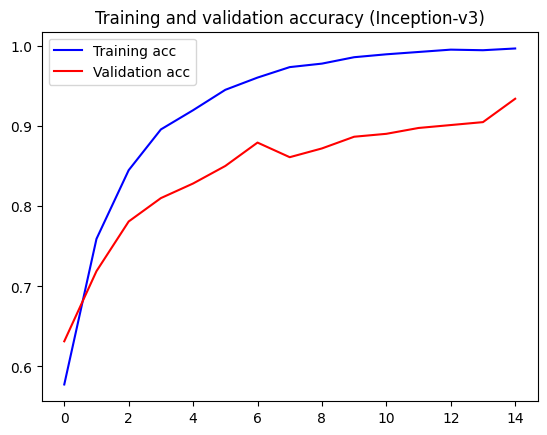

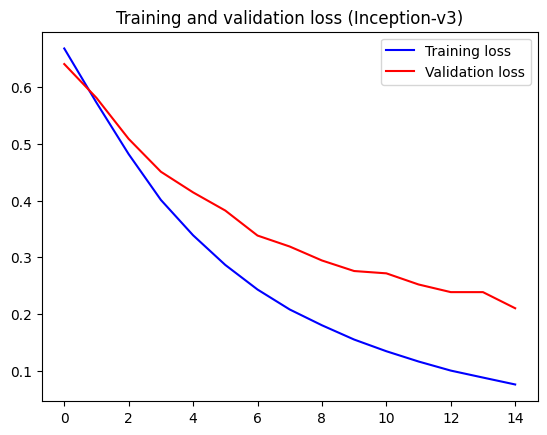

In [ ]:
from matplotlib import pyplot as plt

# Visualizar el rendimiento del modelo durante el entrenamiento
acc_inception = history_inception.history['accuracy']
val_acc_inception = history_inception.history['val_accuracy']
loss_inception = history_inception.history['loss']
val_loss_inception = history_inception.history['val_loss']

epochs_inception = range(len(acc_inception))

# Graficar la precisión
plt.plot(epochs_inception, acc_inception, 'b', label='Training acc')
plt.plot(epochs_inception, val_acc_inception, 'r', label='Validation acc')
plt.title('Training and validation accuracy (Inception-v3)')
plt.legend()
plt.figure()

# Graficar la pérdida
plt.plot(epochs_inception, loss_inception, 'b', label='Training loss')
plt.plot(epochs_inception, val_loss_inception, 'r', label='Validation loss')
plt.title('Training and validation loss (Inception-v3)')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
from IPython.display import HTML

# Valores finales:
resultados = np.array([[history_inception.history['accuracy'][-1],
                        history_inception.history['loss'][-1]],
                       [history_inception.history['val_accuracy'][-1],
                        history_inception.history['val_loss'][-1]]])

df = pd.DataFrame(resultados, index = ['Entrenamiento','Validación'],
                  columns = ['Precisión','Pérdida'])

display(HTML(df.to_html()))

,Precisión,Pérdida
Entrenamiento,0.997091,0.076048
Validación,0.934307,0.210319


#### **Comprobando la precisión con los datos de prueba**

In [ ]:
# Para liberar memoria y que no se quedé sin espacio en RAM
a = %who_ls
a.remove('model_inception')
a.remove('test_features')
a.remove('test_labels')
a.remove('resultados')
for i in a:
  del globals()[i]

In [ ]:
# Evaluar el modelo con datos de prueba
test_loss_inception, test_acc_inception = model_inception.evaluate(test_features, test_labels)

# Imprimir los resultados de la evaluación con los datos de prueba
print(f'Los resultados de la evaluación con los datos de prueba fueron:\n'
      f'Precisión: {test_acc_inception:.4f}\nPérdida: {test_loss_inception:.4f}')

16/16 [==============================] - 8s 485ms/step - loss: 0.1620 - accuracy: 0.9540
Los resultados de la evaluación con los datos de prueba fueron:
Precisión: 0.9540
Pérdida: 0.1620


In [ ]:
import numpy as np
import pandas as pd
from IPython.display import HTML

# Precisión: Tasa de clasifiación correcta.
# Pérdida  : Cuán cerca está la salida del modelo de las etiquetas reales.
resultados = np.vstack((resultados, [test_acc_inception,test_loss_inception]))
df = pd.DataFrame(resultados, index = ['Entrenamiento','Validación','Test'],
                  columns = ['Precisión','Pérdida'])
display(HTML(df.to_html()))

,Precisión,Pérdida
Entrenamiento,0.997091,0.076048
Validación,0.934307,0.210319
Test,0.954000,0.162024


#### **Guardar modelo**

In [ ]:
import os
os.chdir('..')
# Guardar el modelo Inception-v3
model_inception.save('inceptionv3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


---

### **ONE-SHOT LEARNING**

Uno de los principales problemas de los modelos presentados anteriormente es que si la firma no existía dentro de la base de datos no es posible que los modelos identifiquen si la firma es falsa o verdadera y por ende cada vez que queramos reconocer una nueva firma deberíamos re entrenar el modelo por ello este tipo de modelos es importante.

Un modelo one-shot learning se basa en analizar el grado de similiritud entre dos imágenes para definir si estás pertenecen a la misma clase o no por esta razón necesitamos hacer un preprocesamiento de los datos distintos para el one-shot pues necesitamos parejas de imagenes genuinas-genuinas y genuinas-falsas.

Otra ventaja de este tipo de modelos es que necesitan una menor cantidad de datos para su entrenamiento por lo que usaremos sólo los datos de la carpeta train para entrenar nuestro modelo. Veremos más adelante que aún con menos datos el modelo se comporta mucho mejor que los vistos anteriormente.


In [ ]:
import os
import cv2
from tqdm import tqdm
from google.colab import drive
from google.colab.patches import cv2_imshow
drive.mount('/content/drive')
os.chdir('/content/drive/Shareddrives/2023-II/2023-II. Inteligencia Artificial (IA)/Proyecto IA/signature_data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



#### **Preprocesamiento de datos para one-shot learning**

Como se dijo anteriormente, necesitamos cargar las imágenes de a pares y si no de a pares por lo menos necesitamos saber cuáles imágenes de firmas genuinas y falsas pertenecen a la misma persona. Hay muchas formas de hacer esto, pero como el modelo puede obtener un gran rendimiento con pocos datos haremos que las firmas de la misma persona tenga la misma cantidad de firmas falsas y firmas genuinas:

In [ ]:
# Nuevamente definimos el mismo alto y ancho
mean_width = 650
mean_height = 268

In [ ]:
os.mkdir('../signature_data_one_shot')
os.chdir('../signature_data_one_shot')
os.mkdir('train_data')
os.mkdir('validation_data')
os.mkdir('test_data')

In [ ]:
os.chdir('signature_data_one_shot')

Obtenemos la cantidad de firmas falsas y verdaderas que hay en la base de datos para cada persona:

In [ ]:
orig_images = []
forg_images = []
for name in tqdm(sorted(os.listdir('../sign_data/train'))):
    if 'forg' in name.lower():
        forg_images.append(len(os.listdir('../sign_data/train/'+name)))
    else:
        orig_images.append(len(os.listdir('../sign_data/train/'+name)))

100%|██████████| 128/128 [00:12<00:00, 10.27it/s]


La cantidad de imágenes que dejaremos será:

In [ ]:
num_orig = min(orig_images)
num_forg = min(forg_images)
print(num_orig, num_forg)

12 8


In [ ]:
tot_people = len(os.listdir('../sign_data/train'))//2
tot_people

64

In [ ]:
num_train = 100
num_validation = 14
num_test = 14
for name in tqdm(sorted(os.listdir('../sign_data/train'))):
    if num_train > 0:
        os.mkdir('train_data/'+name)
        if 'forg' in name.lower():
            i = num_forg
        else:
            i = num_orig
        for image_name in sorted(os.listdir('../sign_data/train/'+name)):
            if i <= 0:
                break
            img = cv2.imread('../sign_data/train/'+name+'/'+image_name)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img_resized = cv2.resize(img_gray, (mean_width, mean_height))
            cv2.imwrite('train_data/'+name+'/'+image_name, img_resized)
            i -= 1
        num_train -= 1
    elif num_validation > 0:
        os.mkdir('validation_data/'+name)
        if 'forg' in name.lower():
            i = num_forg
        else:
            i = num_orig
        for image_name in sorted(os.listdir('../sign_data/train/'+name)):
            if i <= 0:
                break
            img = cv2.imread('../sign_data/train/'+name+'/'+image_name)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img_resized = cv2.resize(img_gray, (mean_width, mean_height))
            cv2.imwrite('validation_data/'+name+'/'+image_name, img_resized)
            i -= 1
        num_validation -= 1
    elif num_test > 0:
        os.mkdir('test_data/'+name)
        if 'forg' in name.lower():
            i = num_forg
        else:
            i = num_orig
        for image_name in sorted(os.listdir('../sign_data/train/'+name)):
            if i <= 0:
                break
            img = cv2.imread('../sign_data/train/'+name+'/'+image_name)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img_resized = cv2.resize(img_gray, (mean_width, mean_height))
            cv2.imwrite('test_data/'+name+'/'+image_name, img_resized)
            i -= 1
        num_test -= 1

Note que las bases de datos de validación, test y entrenamiento son todas de personas distintas.

In [ ]:
os.chdir('../signature_data_one_shot')
for i in os.listdir():
    personas = os.listdir(i)
    personas = set([persona.split('_')[0] for persona in personas])
    personas = sorted(list(personas))
    print(f'Para la carpeta de {i} están los siguientes números de personas:\n')
    for j in personas:
        print(f'- {j}', end = '\t\t')
    print('\n')

Para la carpeta de train_data están los siguientes números de personas:

- 001		- 002		- 003		- 004		- 006		- 009		- 012		- 013		- 014		- 015		- 016		- 017		- 018		- 019		- 020		- 021		- 022		- 023		- 024		- 025		- 026		- 027		- 028		- 029		- 030		- 031		- 032		- 033		- 034		- 035		- 036		- 037		- 038		- 039		- 040		- 041		- 042		- 043		- 044		- 045		- 046		- 047		- 048		- 049		- 050		- 051		- 052		- 053		- 054		- 055		

Para la carpeta de validation_data están los siguientes números de personas:

- 056		- 057		- 058		- 059		- 060		- 061		- 062		

Para la carpeta de test_data están los siguientes números de personas:

- 063		- 064		- 065		- 066		- 067		- 068		- 069		



#### **Lectura y almacenamiento de los datos**

In [ ]:
import os
import cv2
from tqdm import tqdm
from google.colab import drive
from google.colab.patches import cv2_imshow

drive.mount('/content/drive')
os.chdir('/content/drive/Shareddrives/2023-II/2023-II. Inteligencia Artificial (IA)/Proyecto IA/signature_data_one_shot')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def get_data(dir):
    orig = []
    forg = []
    for name in tqdm(sorted(os.listdir(dir))):
        original = []
        forged = []
        for image_name in sorted(os.listdir(dir+'/'+name)):
            img = dir+'/'+name+'/'+image_name
            if 'forg' in name.lower():
                forged.append(img)
            else:
                original.append(img)

        if 'forg' in name.lower():
            forg.append(forged)
        else:
            orig.append(original)

    return orig, forg

In [ ]:
train_orig, train_forg = get_data('train_data')
validation_orig, validation_forg = get_data('validation_data')
test_orig, test_forg = get_data('test_data')

100%|██████████| 14/14 [00:00<00:00, 1393.52it/s]


In [ ]:
print(len(train_orig))
print(len(train_forg))
print(len(validation_orig))
print(len(validation_forg))
print(len(test_orig))
print(len(test_forg))

50
50
7
7
7
7


#### **Entrenando el modelo**

In [ ]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import itertools
import random
from sklearn.utils import shuffle
from keras import layers
from keras import models
from keras import backend as K

In [ ]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []

        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 12 genuine signatures, hence we have
        # 12 choose 2 = 66 Genuine-Genuine image pairs for one person.
        # To make Genuine-Forged pairs, we pair every Genuine signature of a person
        # with 8 Forged signatures of the same person.
        # Thus we make 12 * 8 = 96 Genuine-Forged image pairs for one person.
        # In all we have 50 person's data in the training data.
        # Total no. of Genuine-Genuine pairs = 50 * 66 = 3300
        # Total number of Genuine-Forged pairs = 50 * 96 = 4800
        # Total no. of data points = 3300 + 4800 = 8100
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(orig)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], forg)))

        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)

        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)

        k = 0
        pairs=[np.zeros((batch_size, 268, 650, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], cv2.IMREAD_GRAYSCALE)
            img2 = cv2.imread(pair[1], cv2.IMREAD_GRAYSCALE)
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                targets = targets.astype(int)
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, 268, 650, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

In [ ]:
# Obtener el primer lote del generador
primer_lote = next(generate_batch(test_orig, test_forg,1))

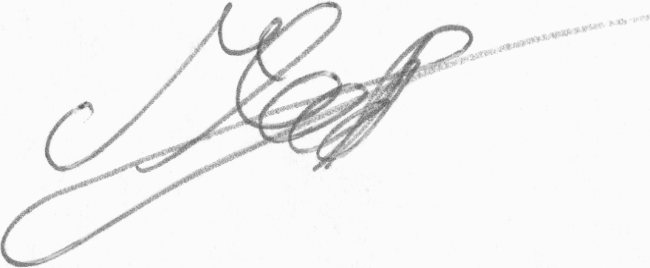

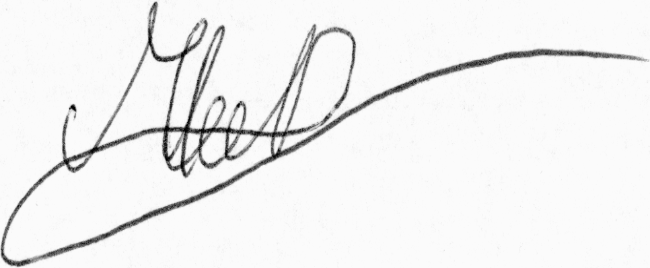

1

In [ ]:
cv2_imshow(primer_lote[0][0][0] * 255)
cv2_imshow(primer_lote[0][1][0] * 255)

len(primer_lote[1])

In [ ]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [ ]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [ ]:
def create_base_network_signet(input_shape):
    '''Base Siamese Network'''

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape,padding='same'))
    model.add(layers.MaxPooling2D((2, 2),padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
    model.add(layers.MaxPooling2D((2, 2),padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
    model.add(layers.MaxPooling2D((2, 2),padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))

    return model

In [ ]:
input_shape=(268, 650, 1)
base_network = create_base_network_signet(input_shape)

input_a = layers.Input(shape=(input_shape))
input_b = layers.Input(shape=(input_shape))

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = layers.Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
prediction = layers.Dense(1,activation='sigmoid')(distance)

model = models.Model(inputs=[input_a, input_b], outputs=prediction)

In [ ]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
num_train_samples = 66*50 + 96*50
num_val_samples = 66*7 + 96*7
num_train_samples, num_val_samples

(8100, 1134)

In [ ]:
import time

strat_time = time.time()
batch_size=64
history = model.fit(generate_batch(train_orig, train_forg, batch_size),
                   steps_per_epoch = num_train_samples//batch_size,
                   epochs = 4,
                   validation_data = generate_batch(validation_orig, validation_forg, batch_size),
                   validation_steps = num_val_samples//batch_size)
end_time = time.time()

Epoch 1/4
126/126 [==============================] - 548s 4s/step - loss: 0.3431 - accuracy: 0.8255 - val_loss: 0.2762 - val_accuracy: 0.9697
Epoch 2/4
126/126 [==============================] - 117s 930ms/step - loss: 0.2603 - accuracy: 0.9888 - val_loss: 0.2566 - val_accuracy: 1.0000
Epoch 3/4
126/126 [==============================] - 118s 937ms/step - loss: 0.2344 - accuracy: 0.9929 - val_loss: 0.2408 - val_accuracy: 1.0000
Epoch 4/4
126/126 [==============================] - 119s 949ms/step - loss: 0.2124 - accuracy: 0.9948 - val_loss: 0.1997 - val_accuracy: 1.0000


#### **Resultados**

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 268, 650, 1)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 268, 650, 1)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128)                  1829023   ['input_1[0][0]',             
                                                          36         'input_2[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 1)                    0         ['sequential[0][0]',      

In [ ]:
print(f'El modelo tardo {(end_time - strat_time)/60} minutos en entrenarse.')

El modelo tardo 16.278459429740906 minutos en entrenarse.


##### Precisión y pérdida

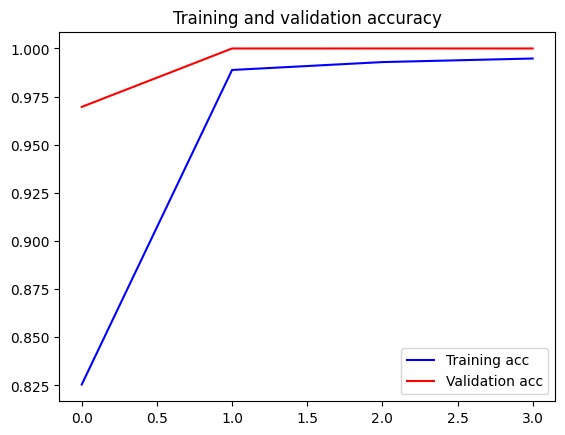

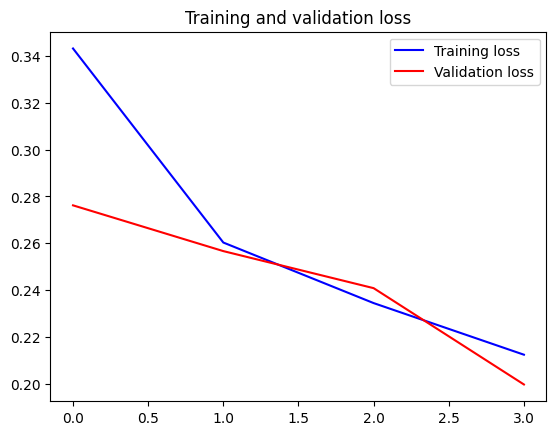

In [ ]:
from matplotlib import pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
import pandas as pd
from IPython.display import HTML

# Valores finales:
resultados = np.array([[history.history['accuracy'][-1],
                        history.history['loss'][-1]],
                       [history.history['val_accuracy'][-1],
                        history.history['val_loss'][-1]]])

df = pd.DataFrame(resultados, index = ['Entrenamiento','Validación'],
                  columns = ['Precisión','Pérdida'])

display(HTML(df.to_html()))

,Precisión,Pérdida
Entrenamiento,0.994792,0.212408
Validación,1.000000,0.199699


#### **Comprobando la precisión con los datos de prueba**

In [ ]:
# Para liberar RAM
a = %who_ls
a.remove('model')
a.remove('test_forg')
a.remove('test_orig')
a.remove('resultados')
a.remove('generate_batch')
a.remove('itertools')
a.remove('random')
a.remove('shuffle')
a.remove('np')
a.remove('cv2')
for i in a:
  del globals()[i]

In [ ]:
num_test_samples = 66*7 + 96*7
test_loss, test_acc = model.evaluate(generate_batch(test_orig, test_forg, 1), steps=num_test_samples)

1134/1134 [==============================] - 53s 46ms/step - loss: 0.2038 - accuracy: 1.0000


In [ ]:
print(f'Los resultados de la evaluación con los datos de prueba fueron:\n'
      f'- Precisión: {test_acc:.4f}\n- Pérdida: {test_loss:.4f}')

Los resultados de la evaluación con los datos de prueba fueron:
- Precisión: 1.0000
- Pérdida: 0.2038


In [ ]:
import numpy as np
import pandas as pd
from IPython.display import HTML

# Precisión: Tasa de clasifiación correcta.
# Pérdida  : Cuán cerca está la salida del modelo de las etiquetas reales.
resultados = np.vstack((resultados, [test_acc,test_loss]))
df = pd.DataFrame(resultados, index = ['Entrenamiento','Validación','Test'],
                  columns = ['Precisión','Pérdida'])
display(HTML(df.to_html()))

,Precisión,Pérdida
Entrenamiento,0.994792,0.212408
Validación,1.000000,0.199699
Test,1.000000,0.203807


#### **Guardando el modelo**

In [ ]:
import os
os.chdir('..')
model.save('oneshot.h5')

#### **Matriz de confusión**

In [ ]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import itertools
import random
from sklearn.utils import shuffle
from keras import layers
from keras import models
from keras import backend as K

os.chdir('/content/drive/Shareddrives/2023-II/2023-II. Inteligencia Artificial (IA)/Proyecto IA/signature_data_one_shot')
model = models.load_model('../oneshot.h5')

In [ ]:
num_test_samples = 66*7 + 96*7
# num_test_samples = 10
true_labels = []
predicted_labels = []
for i in tqdm(range(1,num_test_samples)):
    a = next(generate_batch(test_orig, test_forg, 1))
    true_labels.append(a[1][0])
    if model.predict(a[0], verbose = 0) < 0.5:
      predicted_labels.append(0)
    else:
      predicted_labels.append(1)

100%|██████████| 1133/1133 [01:45<00:00, 10.70it/s]


In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import numpy as np

confussion = tf.math.confusion_matrix(
    true_labels,
    predicted_labels
)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print("Informe de Clasificación:")
print(classification_report(true_labels, predicted_labels))

Informe de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       644
           1       1.00      1.00      1.00       489

    accuracy                           1.00      1133
   macro avg       1.00      1.00      1.00      1133
weighted avg       1.00      1.00      1.00      1133



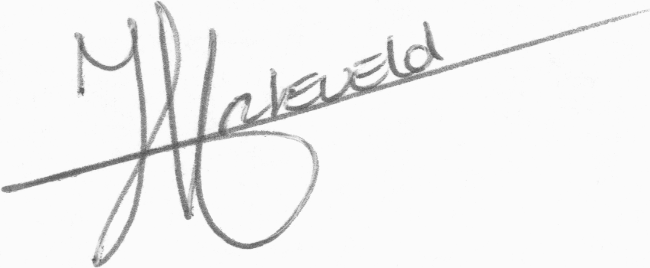

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(a[0][1][0] * 255)

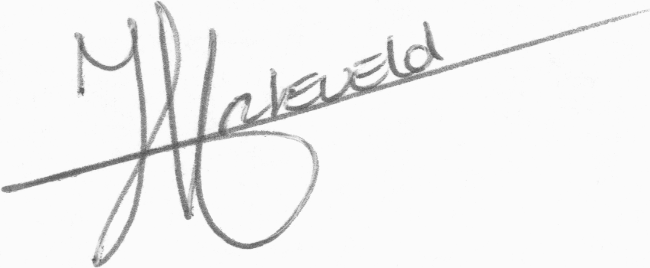

In [ ]:
cv2_imshow(a[0][1][0] * 255)

In [ ]:
a[1][0], predicted_labels[-1]

(1, 1)

In [ ]:
true_labels == predicted_labels

True